In [1]:
DEBUG = False

In [2]:
import os
import gc
import cv2
import time
import timm
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import albumentations
from pylab import rcParams
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.cuda.amp as amp
from torch.utils.data import  Dataset
import torch.nn.functional as F

%matplotlib inline
rcParams['figure.figsize'] = 20, 8
device = torch.device('cuda')
torch.backends.cudnn.benchmark = True

# Config

In [3]:
kernel_type = '0920_1bonev2_effv2s_224_15_6ch_augv2_mixupp5_drl3_rov1p2_bs8_lr23e5_eta23e6_50ep'
load_kernel = None

n_folds = 5
#backbone = 'tf_efficientnetv2_s.in21k_ft_in1k'
#backbone="tf_efficientnetv2_b3.in21k_ft_in1k"
backbone="tf_efficientnetv2_b0.in1k"

image_size = 296

n_slice_per_c = 104 # all abdomen
in_chans = 4

init_lr = 2e-4
eta_min = 0
batch_size = 1
drop_rate = 0.
drop_rate_last = 0.5 #  0.1
drop_path_rate = 0.2
p_mixup = 0.0 #0 0.3
p_rand_order_v1 = 0.0

data_dir = './bowel'
use_amp = True
num_workers = 6
out_dim = 2

n_epochs = 10

log_dir = './logs'
model_dir = './models_bowel'
os.makedirs(log_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

In [4]:
border_mode=cv2.BORDER_CONSTANT
transforms_train = albumentations.Compose([
    albumentations.Resize(image_size, image_size),
    albumentations.HorizontalFlip(p=0.3),
    albumentations.VerticalFlip(p=0.3),
    albumentations.Transpose(p=0.3),
    albumentations.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, brightness_by_max=False, always_apply=False, p=0.5),

    #border_mode=cv2.BORDER_REFLECT101
    albumentations.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=20, border_mode=border_mode, p=0.5),

    albumentations.OneOf([
        albumentations.MotionBlur(blur_limit=3),
        albumentations.MedianBlur(blur_limit=3),
        albumentations.GaussianBlur(blur_limit=(1,3)),
        albumentations.GaussNoise(var_limit=(3.0, 9.0)),
    ], p=0.2),
    albumentations.OneOf([
        albumentations.OpticalDistortion(distort_limit=.1,border_mode=border_mode),
        albumentations.GridDistortion(num_steps=3, distort_limit=.1,border_mode=border_mode),
    ], p=0.5),
    albumentations.Cutout(max_h_size=int(image_size * 0.25), max_w_size=int(image_size * 0.25), num_holes=2, p=0.5),
])

transforms_valid = albumentations.Compose([
    albumentations.Resize(image_size, image_size),
])

/home/sronen/code/.venv/lib/python3.10/site-packages/albumentations/augmentations/dropout/cutout.py:49: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


# DataFrame

In [5]:
from sklearn.model_selection import KFold

organ_dict = {
    0: 'bowel',
    1: 'extravasation',
}

df_p = pd.read_csv('/kaggle/input/rsna-2023-abdominal-trauma-detection/train.csv')





df_s=pd.read_csv('/kaggle/input/rsna-2023-abdominal-trauma-detection/train_series_meta.csv')

df_p['fold'] = -1
kf = KFold(5,shuffle=True,random_state=42)
for fold, (train_idx, valid_idx) in enumerate(kf.split(df_p,df_p)):
    df_p.loc[valid_idx, 'fold'] = fold


#df_healthy=df_p[df_p["any_injury"]==0].sample(758)
#df_injured=df_p[(df_p["kidney_healthy"]==0) | (df_p["liver_healthy"]==0)| (df_p["spleen_healthy"]==0) | (df_p["bowel_healthy"]==0)]
#print(len(df_injured),len(df_healthy))
#df_p1=pd.concat((df_healthy,df_injured))


df=df_p.merge(df_s,on="patient_id")
df["count"]=df.groupby(["patient_id"])["patient_id"].transform("count")


pid=[]
sid = []
cs = []
label = []
fold = []
hu=[]
counts=[]
lbowel=[]
lextra=[]
for row in df.to_dict(orient="records"):
        pid.append(row["patient_id"])
        sid.append(row["series_id"])
        hu.append(row["aortic_hu"])
        la=[row["bowel_injury"],row["extravasation_injury"]]
        label.append(la)
        lbowel.append(la[0])
        lextra.append(la[1])
        fold.append(row["fold"])
        counts.append(row["count"])

df = pd.DataFrame({
    'patient_id': pid,
    'series_id': sid,
    'hu':hu,
    'label': label,
    'bowel':lbowel,
    "extravasation":lextra,
    'fold': fold,
    'counts':counts,
})

#pd.set_option('display.max_rows', None)
df = df.sample(16).reset_index(drop=True) if DEBUG else df
#df_image=pd.read_csv("/kaggle/input/rsna-2023-abdominal-trauma-detection/image_level_labels.csv")
#df_image=df_image.groupby(["patient_id","series_id"]).injury_name.value_counts().unstack(fill_value=0)
#df_image=(df_image>0).reset_index()
#print(df_image.head(100))
df.to_csv("df_stage2b.csv")
len(df)


4711

In [6]:
print(len(df_p),len(df_s))


3147 4711


# Dataset

In [7]:
class CLSDataset(Dataset):
    def __init__(self, df, mode, transform):

        self.df = df.reset_index()
        self.mode = mode
        self.transform = transform

    def __len__(self):
        return self.df.shape[0]

    def __getitem__(self, index):
        row = self.df.iloc[index]
        images = []
        
        filepath=os.path.join(data_dir, f'{row.patient_id}_{row.series_id}.npz')
        data = np.load(filepath)
        image3d=data['arr_0'] # slice,channel,H,W

        if self.mode=="train":    
            select_ind = np.random.choice(list(range(image3d.shape[0])),n_slice_per_c,replace=False)
            select_ind = np.sort(select_ind)
        else:
            # select_ind = np.random.choice(list(range(image3d.shape[0])),100,replace=False)
            select_ind=list(range(image3d.shape[0]))

        #for ind in list(range(n_slice_per_c)):
        for ind in select_ind:
            image=image3d[ind,...].transpose(1,2,0).astype(np.uint8)
            image = self.transform(image=image)['image']
            image = image.transpose(2, 0, 1).astype(np.float32) / 255.
            images.append(image)
        images = np.stack(images, 0)
        images=torch.tensor(images).float()
        #hu=row.hu
        #scaled_hu=(hu+300)/700
        #images[:,:3,:,:]=images[:,:3,:,:]-scaled_hu

        if self.mode != 'test':
            labels=data['arr_1'][select_ind]  # slice
            labels = torch.tensor(labels).float()
            counts=torch.tensor([row.counts]*len(labels)).float()
            
            #images[...]=0.
            #images[:,:,:,:3]=labels[:,None,None,:]
            #images[:,0,0,:3]=labels[:,:]

         
            
            if self.mode == 'train' and random.random() < p_rand_order_v1:
                indices = torch.randperm(images.size(0))
                images = images[indices]
                labels = labels[indices]
                counts=counts[indices]

            return images, labels,counts
        else:
            return images

In [8]:
rcParams['figure.figsize'] = 20,8

df_show = df
dataset_show = CLSDataset(df_show, 'train', transform=transforms_train)
loader_show = torch.utils.data.DataLoader(dataset_show, batch_size=batch_size, shuffle=True, num_workers=num_workers)

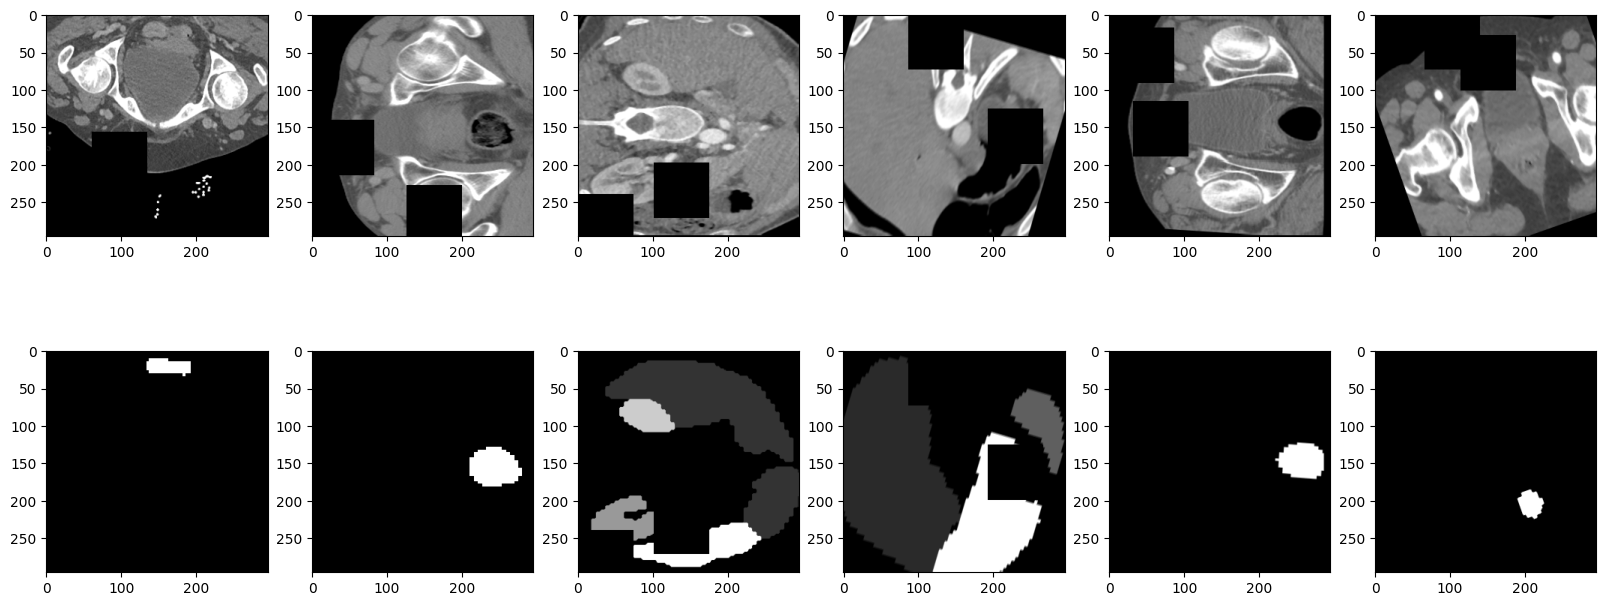

In [9]:
f, axarr = plt.subplots(2,6)
for p in range(6):
    idx = p * 20
    imgs, lbl,_ = dataset_show[idx]
    sel=7
    axarr[0, p].imshow(255*imgs[sel][1],cmap="gray")
    axarr[1, p].imshow(imgs[sel][-1],cmap="gray")

# Model

In [10]:
class Attention(nn.Module):
    def __init__(self, feature_dim, **kwargs):
        super().__init__(**kwargs)
        
        self.supports_masking = True

        self.feature_dim = feature_dim
        self.features_dim = 0
        
        weight = torch.zeros(feature_dim, 1)
        nn.init.xavier_uniform_(weight)
        self.weight = nn.Parameter(weight)
        
    def forward(self, x, mask=None):
        step_dim=x.shape[1]
        feature_dim = self.feature_dim
        eij = torch.mm(
            x.contiguous().view(-1, feature_dim), 
            self.weight
        ).view(-1, step_dim)
        
        eij = torch.tanh(eij)
        a = torch.exp(eij) # slice importances
        
        if mask is not None:
            a = a * mask

        a = a / torch.sum(a, 1, keepdim=True) + 1e-10 # normalize across slices

        weighted_input = x * torch.unsqueeze(a, -1)
        return torch.sum(weighted_input, 1)


In [11]:
class TimmModel(nn.Module):
    def __init__(self, backbone, pretrained=False,features=False):
        super(TimmModel, self).__init__()
        self.features=features
        self.encoder = timm.create_model(
            backbone,
            in_chans=in_chans,
            num_classes=out_dim,
            features_only=False,
            drop_rate=drop_rate,
            drop_path_rate=drop_path_rate,
            pretrained=pretrained
        )

        if 'efficient' in backbone:
            hdim = self.encoder.conv_head.out_channels
            self.encoder.classifier = nn.Identity()
        elif 'convnext' in backbone:
            hdim = self.encoder.head.fc.in_features
            self.encoder.head.fc = nn.Identity()

        hlstm=64
        self.lstm = nn.LSTM(hdim, hlstm, num_layers=1, dropout=drop_rate, bidirectional=True, batch_first=True)
        self.head = nn.Sequential(
            nn.Linear(2*hlstm, hlstm),
            nn.BatchNorm1d(hlstm),
            nn.Dropout(drop_rate_last),
            nn.LeakyReLU(0.1),
            nn.Linear(hlstm, out_dim),
        )
        self.head2=nn.Linear(4*hlstm,out_dim)
        self.attention=Attention(2*hlstm)

    def forward(self, x):  # (bs, nslice, ch, sz, sz)
        bs = x.shape[0]
        nslices=x.shape[1]
        x = x.view(bs * nslices, in_chans, image_size, image_size)
        feat = self.encoder(x)
        feat = feat.view(bs, nslices, -1)
        feat, _ = self.lstm(feat)
        
        featv = feat.contiguous().view(bs * nslices, -1)
        out = self.head(featv)
        out = out.view(bs, nslices,out_dim).contiguous()
        
        att=self.attention(feat)
        max_=feat.max(dim=1)[0]
        conc=torch.cat((att,max_),dim=1)
        out2=self.head2(conc)


        if self.features:
            return feat
        else:
            return out,out2

In [12]:
from torchinfo import summary
#summary(m,(1,n_slice_per_c,in_chans,image_size,image_size))
m = TimmModel(backbone)

print(summary(m,(2,n_slice_per_c,in_chans,image_size,image_size)))
#dummy=torch.rand((2,30,in_chans,image_size,image_size)).float().cuda()
#m=m.cuda()
#m(dummy).shape

Layer (type:depth-idx)                             Output Shape              Param #
TimmModel                                          [2, 104, 2]               --
├─EfficientNet: 1-1                                [208, 1280]               --
│    └─Conv2dSame: 2-1                             [208, 32, 148, 148]       1,152
│    └─BatchNormAct2d: 2-2                         [208, 32, 148, 148]       64
│    │    └─Identity: 3-1                          [208, 32, 148, 148]       --
│    │    └─SiLU: 3-2                              [208, 32, 148, 148]       --
│    └─Sequential: 2-3                             [208, 192, 10, 10]        --
│    │    └─Sequential: 3-3                        [208, 16, 148, 148]       4,640
│    │    └─Sequential: 3-4                        [208, 32, 74, 74]         52,736
│    │    └─Sequential: 3-5                        [208, 48, 37, 37]         136,000
│    │    └─Sequential: 3-6                        [208, 96, 19, 19]         230,652
│    │    └─Seq

In [13]:
from torchvision.ops import sigmoid_focal_loss

global_weight_bowel=(np.sum(df["bowel"]==0)+2*np.sum(df["bowel"]==1))/len(df)
global_weight_extra=(np.sum(df["extravasation"]==0)+6*np.sum(df["extravasation"]==1))/len(df)
print("global weights",global_weight_bowel,global_weight_extra)

bce = nn.BCEWithLogitsLoss(reduction='none')
def criterion(logits, targets,use_weights=False,w=[2,6],focal=False):
    logits=logits.view(-1,out_dim)
    targets=targets.view(-1,out_dim)
    w1=targets[:,0]*(w[0]-1)+1.
    w2=targets[:,1]*(w[1]-1)+1.
    w=torch.stack((w1,w2),dim=1)
    if focal:
        loss=sigmoid_focal_loss(logits,targets,alpha=-1,gamma=1.)
    else:
        loss = bce(logits, targets)
    if use_weights:
        return loss,w
    else:
        loss=torch.mean(loss*w,dim=0)
        loss=(loss[0]/global_weight_bowel+loss[1]/global_weight_extra)/2
        return loss

global weights 1.0220759923583103 1.3184037359371683


In [14]:
from torch.distributions.beta import Beta
beta=Beta(torch.tensor([0.2]),torch.tensor([0.2]))

def mix_up(images1,labels1):
    # Unpack two datasets
    batch_size = images1.shape[0]
    # Sample lambda and reshape it to do the mixup
    l = beta.sample(torch.Size([batch_size])).cuda()
    x_l = l.reshape((batch_size, 1, 1, 1,1))
    y_l = l.reshape((batch_size, 1,1))
    idx = torch.randperm(batch_size).cuda()
    images2=images1[idx,...]
    labels2=labels1[idx,...]
    # Perform mixup on both images and labels by combining a pair of images/labels
    # (one from each dataset) into one image/label
    images = images1 * x_l + images2 * (1 - x_l)
    labels = labels1 * y_l + labels2 * (1 - y_l)
    return (images, labels)


def train_func(model, loader_train, optimizer, scaler,scheduler):
    model.train()
    train_loss = []
    bar = tqdm(loader_train)
    for images, targets,_ in bar:
        optimizer.zero_grad()
        images = images.cuda()
        targets = targets.cuda()
  
        if random.random() < p_mixup:
            images, targets = mix_up(images, targets)


        with amp.autocast():
            logits,logits_series = model(images)
            #logits_series=logits.max(dim=1)[0]
            targets_series=targets.max(dim=1)[0]
            loss_series=criterion(logits_series,targets_series)
            loss_slice = criterion(logits, targets,focal=True)
            loss=loss_series+loss_slice
            #loss=loss_slice

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()
        train_loss.append(loss.item())
            
        bar.set_description(f'smth:{np.mean(train_loss[-100:]):.4f}')

    return np.mean(train_loss)


def valid_func(model, loader_valid,dff):
    model.eval()
    valid_loss=[]
    wa=[]
    bar = tqdm(loader_valid)
    with torch.no_grad():
        for images, targets,counts in bar:
            images = images.cuda()
            targets = targets.cuda()
            counts=counts.cuda()
            
        
            with amp.autocast():
                logits,logits_series = model(images)
                #loss,w=criterion(logits,targets,use_weights=True)
                #logits_series=logits.max(dim=1)[0]
                targets_series=targets.max(dim=1)[0]
                loss_series,w_series=criterion(logits_series,targets_series,use_weights=True)
                loss,w=loss_series,w_series
 

            valid_loss.append(loss.cpu())
            w=w/counts[:,0][:,None]
            wa.append(w.cpu())

            v1=np.concatenate(valid_loss[-100:])
            w1=np.concatenate(wa[-100:])
            smth=np.mean(np.average(v1,weights=w1,axis=0))
            bar.set_description(f'smth:{smth:.4f}')


    v1=np.concatenate(valid_loss)
    w1=np.concatenate(wa)
    valid_loss=np.mean(np.average(v1,weights=w1,axis=0))    
    group_loss=np.average(v1,weights=w1,axis=0)
    print("group loss",group_loss)            
    return valid_loss
            

In [15]:
df.label.value_counts()

label
[0, 0]    4338
[0, 1]     269
[1, 0]      73
[1, 1]      31
Name: count, dtype: int64

In [16]:
del m
torch.cuda.empty_cache()
gc.collect()

14

# Training

In [17]:
from torch.utils.data import WeightedRandomSampler
def run(fold):

    log_file = os.path.join(log_dir, f'{kernel_type}.txt')
    model_file = os.path.join(model_dir, f'{kernel_type}_fold{fold}_best.pth')

    #train_ = df[df['fold'] != fold].reset_index(drop=True)

    train_ = df[(df['fold'] != fold)].reset_index(drop=True) #& ((df["bowel"]>0) | (df["extravasation"]>0)) ].reset_index(drop=True)
    valid_ = df[(df['fold'] == fold)].reset_index(drop=True) #& ((df["bowel"]>0) | (df["extravasation"]>0)) ].reset_index(drop=True)

    

    dataset_train = CLSDataset(train_, 'train', transform=transforms_train)
    dataset_valid = CLSDataset(valid_, 'valid', transform=transforms_valid)
    
  

    class_counts = train_.label.value_counts()
    print("class_counts",class_counts)

    class_w_bowel=[1,1]
    class_w_extravasation=[1,1]
    bowel_weights=[class_w_bowel[i] for i in train_.bowel.values]
    extravasation_weights=[class_w_extravasation[i] for i in train_.extravasation.values]
    sample_train_weights=[max(bowel_weights[i],extravasation_weights[i]) for i in range(len(train_))]
    sample_train_weights=[sample_train_weights[i]/train_.counts.values[i] for i in range(len(train_))]

    nsamp=500
    sampler=WeightedRandomSampler(weights=sample_train_weights,num_samples=nsamp)
    loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, num_workers=num_workers, drop_last=True,sampler=sampler)

    #loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=num_workers, drop_last=True)

    loader_valid = torch.utils.data.DataLoader(dataset_valid, batch_size=4, shuffle=False, num_workers=num_workers)

    model = TimmModel(backbone, pretrained=True)
    model = model.to(device)

    optimizer = optim.AdamW(model.parameters(), lr=init_lr,weight_decay=1e-3)
    scaler = torch.cuda.amp.GradScaler() if use_amp else None

    metric_best = np.inf

    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, n_epochs, eta_min=eta_min)

    print("#train", len(dataset_train), "#valid",len(dataset_valid))

    for epoch in range(1, n_epochs+1):
        print(time.ctime(), 'Epoch:', epoch)
        train_loss = train_func(model, loader_train, optimizer, scaler,scheduler_cosine)
        scheduler_cosine.step(epoch-1)   
        valid_loss = valid_func(model, loader_valid,valid_)
    
        metric = valid_loss

        content = time.ctime() + ' ' + f'Fold {fold}, Epoch {epoch}, lr: {optimizer.param_groups[0]["lr"]:.7f}, train loss: {train_loss:.5f}, valid loss: {valid_loss:.5f}, metric: {(metric):.6f}.'
        print(content)
        with open(log_file, 'a') as appender:
            appender.write(content + '\n')

        if metric < metric_best:
            print(f'metric_best ({metric_best:.6f} --> {metric:.6f}). Saving model ...')
            torch.save(model.state_dict(), model_file)
            metric_best = metric

        # Save Last
        if not DEBUG:
            torch.save(
                {
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'scaler_state_dict': scaler.state_dict() if scaler else None,
                    'score_best': metric_best,
                },
                model_file.replace('_best', '_last')
            )

    del model
    torch.cuda.empty_cache()
    gc.collect()

In [18]:
TRAINING=False
if TRAINING:
    run(0)
    run(1)
    run(2)
    run(3)
    run(4)

# Save features

In [19]:
def infer_features(ifold):
    print(ifold)
    model = TimmModel(backbone, pretrained=False,features=True)
    model_file = os.path.join(model_dir, f'{kernel_type}_fold{ifold}_best.pth')
    model.load_state_dict(torch.load(model_file))
    model = model.to(device)

    dataset = CLSDataset(df, 'test', transform=transforms_valid) 
    save_path=f"features2b/model{ifold}"           
    os.makedirs(save_path,exist_ok=True)
    for ind,row in tqdm(df.iterrows()):
        images = dataset[ind]
        with torch.no_grad():
            images=images.cuda()
            images=images[None,...]
            features = model(images).squeeze()
            features=features.numpy(force=True)
        np.save(f"{save_path}/{row.patient_id}_{row.series_id}",features)
    
    del model
    torch.cuda.empty_cache()
    gc.collect()
    
PREP_FEATURES=False
if PREP_FEATURES:
    infer_features(0)
    infer_features(1)
    infer_features(2)
    infer_features(3)
    infer_features(4)
    

In [20]:
def save_logits(ifold):
    print(ifold)
    model = TimmModel(backbone, pretrained=False)
    model_file = os.path.join(model_dir, f'{kernel_type}_fold{ifold}_best.pth')
    model.load_state_dict(torch.load(model_file))
    model = model.to(device)

    dataset = CLSDataset(df, 'test', transform=transforms_valid) 
    save_path=f"logits2b/model{ifold}"           
    os.makedirs(save_path,exist_ok=True)
    results=[]
    for ind,row in tqdm(df.iterrows()):
        images = dataset[ind]
        with torch.no_grad():
            images=images.cuda()
            images=images[None,...]
            logits = model(images)[1].squeeze()
            logits = logits.numpy(force=True)
            results.append({"patient_id":row.patient_id,"series_id":row.series_id,"logits":logits})
    results=pd.DataFrame(results)
    results.to_csv(f"{save_path}/logits.csv",index=False)
    del model
    torch.cuda.empty_cache()
    gc.collect()
    
SAVE_PROBS=True
if SAVE_PROBS:
    save_logits(0)
    save_logits(1)
    save_logits(2)
    save_logits(3)
    save_logits(4)

0


4711it [41:31,  1.89it/s]


1


4711it [41:10,  1.91it/s]


2


4711it [41:29,  1.89it/s]


3


4711it [42:00,  1.87it/s]


4


4711it [41:25,  1.90it/s]
